<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT22/blob/main/Poisson_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Poisson equation**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Poisson equation, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Poisson equation takes the form

$-\Delta u = f,$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a finite element method to solve the Poisson equation in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the equation by $v\in V$, and then integrate over the domain $\Omega$ and use Green's formula
$
(-\Delta u,v) = (\nabla u, \nabla v) 
- <\nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $u\in V$ such that 

$ (\nabla u,\nabla v) 
- <\nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $v \in V$. 

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad 
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero. 

The equations can be expressed in residual form

$r(u;v) = (\nabla u,\nabla v) - (f,v)$

# **Method**

**Define domain and mesh**

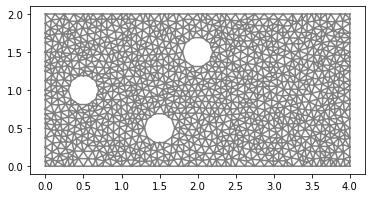

In [3]:
# Define rectangular domain 
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
#mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5,0.5*H),0.2), resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [4]:
# Generate finite element space
VE = FiniteElement("CG", mesh.ufl_cell(), 1)

V = FunctionSpace(mesh, VE)

# Define trial and test functions
u = Function(V)
v = TestFunction(V) 

**Define boundary conditions**

In [5]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
#uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)"), YMAX=YMAX, element = V.ufl_element()) 
uin = 1.0
uw = 0.0
uout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = V.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = V.ufl_element()) 
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = V.ufl_element())

# **Results**

**Define and solve variational problem**

In [6]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( inner(grad(u), grad(v))*dx + gamma*(ib*inner(u - uin, v) + wb*inner(u - uw, v) + ob*inner(u - uout, v))*ds - inner(f, v)*dx )

# Solve algebraic system 
solve(residual == 0, u) 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory


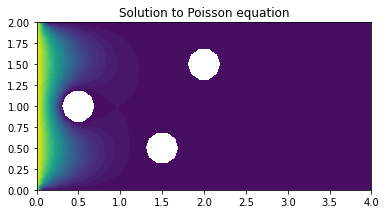

In [7]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Poisson/u.pvd")

# Save solution to file
file_u << u

# Plot solution
plt.figure()
plot(u, title="Solution to Poisson equation")
        
plt.show()

# Export files
#!tar -czvf results-Poisson.tar.gz results-Poisson
#files.download('results-Poisson.tar.gz')

# **Discussion**

A finite element method was implemented in FEniCS to solve the Poisson equation in 2D. The method was tested for the model problem of flow past a number of circular obstacles, and the solution behaved as expected.  